<a href="https://colab.research.google.com/github/mehtamohit013/comms_lidar_ML/blob/main/BS_Selection/BS_sel_with_fed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab - Once per runtime

In [1]:
!nvidia-smi

Thu Aug  5 04:08:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%%capture _
!unzip /gdrive/MyDrive/BTP/webots_data/data.zip
# !unzip /gdrive/MyDrive/BTP/Webots_data/val_data.zip
!pip install pytorch-lightning


# Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from enum import Enum

import numpy as np
import os
import matplotlib.pyplot as plt
import random
import scipy.io as io
import math
import getpass
import time
from typing import Union

import pytorch_lightning as pl

seed = 0

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Hyper-params

In [2]:
user = getpass.getuser()

if user == 'root':  #For google colab
    data_dir = '.'
elif user == 'mohit':
    data_dir = os.environ['HOME'] + '/webots_code/data'
elif user == 'iiti':
    data_dir = os.environ['HOME'] + '/webots_code/data'
else:
    print(f'User {user} not present.\n Exiting.....')
    exit(0)

train_dir = os.path.join(data_dir,'train')
val_dir = os.path.join(data_dir,'val')

#Train Path
train_lpath = os.path.join(train_dir, 'lidar')
train_cpath = os.path.join(train_dir, 'gps')
train_label_path = os.path.join(train_dir,'label')

# Val Path
val_lpath = os.path.join(val_dir, 'lidar')
val_cpath = os.path.join(val_dir, 'gps')
val_label_path = os.path.join(val_dir,'label')


len_train = len(os.listdir(train_lpath))
len_val = len(os.listdir(val_lpath))
BS = np.array([
    [38.89502,-77.07303,5],
    [38.89442,-77.07294,5],
    [38.89452,-77.07358,5]
])
num_BS = int(BS.shape[0])

BATCH_SIZE = 4 

if (user=='root'):
    n_worker = 2
else:
    n_worker = 8

save_dir = os.path.join(os.environ['HOME'],'webots_code/model_state_dict')
os.makedirs(save_dir,exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Utilities

In [3]:
def top_k_acc(y_true:torch.Tensor,y_pred:torch.Tensor,k=1):
    
    y_pred_tpk = torch.topk(y_pred,k,dim=1)[1]
    
    ovr = 0
    pos = 0

    for i in range(0,len(y_pred_tpk)):
        if(y_true[i] in y_pred_tpk[i]):
            pos+=1
        ovr+=1
    
    acc = float(pos)/float(ovr)
    return acc

# Creating Dataset and Dataloader

## Custom Dataset
Using 'GPS' currently.Translation can also be used instead of gps

In [4]:
class bs_dataset(Dataset):
    def __init__(self,lpath:str,cpath:str,
                 label_path:str,len_data:int,
                 fileidx:list,BS:np.ndarray):
    
        self.lpath = lpath
        self.cpath = cpath
        self.label_path = label_path
        self.len_data = len_data
        self.fileidx = fileidx
        self.BS = BS #[num_BS,3]
        
    def __getitem__(self,index):
        sample = dict() 
        idx = self.fileidx[index]

        sample['lidar'] = dict(np.load(self.lpath+f'/{idx}.npz'))['lidar'] #[10,240,240]
        sample['lidar'] = sample['lidar'].astype('float32')
        sample['gps'] = io.loadmat(self.cpath+f'/{idx}.mat')['gps']
        sample['gps'] = sample['gps'][1].astype('float32').reshape((3,)) #[3,]
        sample['BS'] = self.BS.reshape((3*num_BS,)).astype('float32') #[num_BS*3,]
        sample['label'] = io.loadmat(self.label_path+f'/{idx}.mat')['ss']
        
        #Return the index of maximum element 
        sample['label'] = np.argmax(sample['label'].astype('float32')) 
        
        return sample
    
    def __len__(self):
        return self.len_data

In [5]:
train_dataset = bs_dataset(train_lpath,train_cpath,train_label_path,len_train,range(0,len_train),BS)

In [6]:
val_dataset = bs_dataset(val_lpath,val_cpath,val_label_path,len_val,range(0,len_val),BS)

## Dataloader

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True,
    shuffle = True
    )

In [8]:
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
    )

# Models
Based on Imperial Model

## Lidar + GPS Class

In [9]:
class bs_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.channels = 5
        self.fchannel = 3
        self.conv1 = nn.Conv2d(10,self.channels, 13, 1, 1)
        self.bn1 = nn.BatchNorm2d(self.channels)
        self.relu1 = nn.PReLU(num_parameters=self.channels)
        self.conv2 = nn.Conv2d(self.channels, self.channels, 13, 1, 1)
        self.bn2 = nn.BatchNorm2d(self.channels)
        self.relu2 = nn.PReLU(num_parameters=self.channels)
        self.conv3 = nn.Conv2d(self.channels, self.channels, 7, 2, 1)
        self.bn3 = nn.BatchNorm2d(self.channels)
        self.relu3 = nn.PReLU(num_parameters=self.channels)
        self.conv4 = nn.Conv2d(self.channels, self.channels, 7, 1, 1)
        self.bn4 = nn.BatchNorm2d(self.channels)
        self.relu4 = nn.PReLU(num_parameters=self.channels)
        self.conv5 = nn.Conv2d(self.channels, self.fchannel, 5, 2, 1)
        self.bn5 = nn.BatchNorm2d(self.fchannel)
        self.relu5 = nn.PReLU(num_parameters=self.fchannel)
        self.conv6 = nn.Conv2d(self.fchannel, self.fchannel, 5, (1, 2), 1)
        self.bn6 = nn.BatchNorm2d(self.fchannel)
        self.relu6 = nn.PReLU(num_parameters=self.fchannel)
        
        self.flatten = nn.Flatten()
        self.linear7 = nn.Linear(3675,64)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(76, 3)
#         self.linear9 = nn.Linear(64,3)
#         self.linear10 = nn.Linear(16,3)


    def forward(self, x, gps, bs):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        #
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)

        x = self.flatten(x)
        x = self.linear7(x)
        x = self.relu7(x)
        
        out = torch.cat((x,gps,bs),dim=1)
        out = self.linear8(out)
#         out = self.relu7(out)
#         out = self.linear9(out)
#         out = self.relu7(out)
#         out = self.linear10(out)
        
        return out


In [10]:
# # For testing model shape and size
# model = bs_model()lidar = torch.Tensor(2,10,240,240)
# gps = torch.Tensor(2,3)
# BS = torch.Tensor(2,9)
# model(lidar,gps,BS)

## GPS Class

In [11]:
class gps_bs_sel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(12,32)
        self.linear2 = nn.Linear(32,64)
        self.linear3 = nn.Linear(64,32)
        self.linear4 = nn.Linear(32,3)
        
        self.relu = nn.ReLU()
    
    def forward(self,gps,BS):

        x = torch.cat([gps,BS],dim=1)
        
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)

        return out

## Lidar Class

In [12]:
class lidar_bs_sel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.channels = 5
        self.fchannel = 3
        self.conv1 = nn.Conv2d(10,self.channels, 13, 1, 1)
        self.bn1 = nn.BatchNorm2d(self.channels)
        self.relu1 = nn.PReLU(num_parameters=self.channels)
        self.conv2 = nn.Conv2d(self.channels, self.channels, 13, 1, 1)
        self.bn2 = nn.BatchNorm2d(self.channels)
        self.relu2 = nn.PReLU(num_parameters=self.channels)
        self.conv3 = nn.Conv2d(self.channels, self.channels, 7, 2, 1)
        self.bn3 = nn.BatchNorm2d(self.channels)
        self.relu3 = nn.PReLU(num_parameters=self.channels)
        self.conv4 = nn.Conv2d(self.channels, self.channels, 7, 1, 1)
        self.bn4 = nn.BatchNorm2d(self.channels)
        self.relu4 = nn.PReLU(num_parameters=self.channels)
        self.conv5 = nn.Conv2d(self.channels, self.fchannel, 5, 2, 1)
        self.bn5 = nn.BatchNorm2d(self.fchannel)
        self.relu5 = nn.PReLU(num_parameters=self.fchannel)
        self.conv6 = nn.Conv2d(self.fchannel, 1, 5, (1, 2), 1)
        self.bn6 = nn.BatchNorm2d(1)
        self.relu6 = nn.PReLU(num_parameters=1)

        self.flatten = nn.Flatten()
        self.linear7 = nn.Linear(1225,256)
        self.relu7 = nn.ReLU()

        self.linear8 = nn.Linear(256,16)
        self.linear9 = nn.Linear(16,3)

    def forward(self,x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
      
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)

        x = self.flatten(x)
        x = self.linear7(x)
        x = self.relu7(x)

        x = self.linear8(x)
        x= self.relu7(x)

        out = self.linear9(x)

        return out


# Training
Using pytorch lightning

## GPS

### Lightning class

In [13]:
class gps_trainer(pl.LightningModule):
    def __init__(self,learning_rate = 1e-3):
        super().__init__()
        self.model = gps_bs_sel()
        self.celoss = nn.CrossEntropyLoss()
        self.lr = learning_rate
    
    def forward(self,gps,BS):
        out = self.model(gps,BS)
        return out
    
    def training_step(self,batch,batch_idx):
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self(gps,BS)
        
        loss = self.celoss(yhat,label)
        
        self.log('my_loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        top1 = top_k_acc(y_true,y_pred,k=1)

        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        print(f'Test accuracy is {top1}')

### Class object and trainer

In [14]:
# gps_model = gps_trainer()

In [15]:
# gps_pl_trainer = pl.Trainer(reload_dataloaders_every_epoch = True,
#                      gpus=0,
#                      max_epochs = 10,
#                      auto_lr_find = False
#                      )

In [16]:
# gps_pl_trainer.fit(gps_model,train_loader,val_loader)

## Lidar

### Lightning Class

In [17]:
class lidar_trainer(pl.LightningModule):
    def __init__(self,learning_rate = 1e-3):
        super().__init__()
        self.model = lidar_bs_sel()
        self.celoss = nn.CrossEntropyLoss()
        self.lr = learning_rate
    
    def forward(self,lidar):
        out = self.model(lidar)
        return out
    
    def training_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self(lidar)
        
        loss = self.celoss(yhat,label)
        
        self.log('my_loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        top1 = top_k_acc(y_true,y_pred,k=1)

        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        print(f'Test accuracy is {top1}')

### Class object and trainer

In [18]:
# lidar_model = lidar_trainer()

In [19]:
# lidar_pl_trainer = pl.Trainer(reload_dataloaders_every_epoch = True,
#                      gpus=1,
#                      max_epochs = 10,
#                      auto_lr_find = False
#                      )

In [20]:
# lidar_pl_trainer.fit(lidar_model,train_loader,val_loader)

##  GPS + Lidar

### Lightning Class

In [21]:
class BS_trainer(pl.LightningModule):
    def __init__(self,learning_rate = 1e-3):
        super().__init__()
        self.model = bs_model()
        self.celoss = nn.CrossEntropyLoss()
        self.lr = learning_rate
    
    def forward(self,lidar,gps,BS):
        out = self.model(lidar,gps,BS)
        return out
    
    def training_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self(lidar,gps,BS)
        
        loss = self.celoss(yhat,label)
        
        self.log('my_loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        top1 = top_k_acc(y_true,y_pred,k=1)

        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar,gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar,gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        print(f'Test accuracy is {top1}')

### Class object and trainer 

In [22]:
# model = BS_trainer()

In [23]:
# lidar_gps_pl_trainer = pl.Trainer(reload_dataloaders_every_epoch = True,
#                      gpus=1,
#                      max_epochs = 10,
#                      auto_lr_find = False
#                      )

In [24]:
# lidar_gps_pl_trainer.fit(model,train_loader,val_loader)

# Accuracy based on distance

In [25]:
def dist_gps(gps1, gps2):
    lat1, lon1, _ = gps1
    lat2, lon2, _ = gps2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + \
        math.cos(phi_1) * math.cos(phi_2) * \
        math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


In [26]:
y_pred = list()
pos = 0
ovr = 0 
for i in range(0,len_train):
    data = train_dataset[i]
    dist1 = dist_gps(data['gps'],data['BS'][:3])
    dist2 = dist_gps(data['gps'],data['BS'][3:6])
    dist3 = dist_gps(data['gps'],data['BS'][6:9])

    # print(dist1,dist2,dist3)
    
    index = np.argmax(np.array([dist1,dist2,dist3]))

    # print(index,data['label'])

    if index == data['label']:
        pos+=1
    ovr+=1
    # if((i+1)%10==0):
    #     break
print(f'Accuracy based on shortest distance on train is {pos/ovr}')

Accuracy based on shortest distance on train is 0.40597503580928995


In [27]:
y_pred = list()
pos = 0
ovr = 0 
for i in range(0,len_val):
    data = val_dataset[i]
    dist1 = dist_gps(data['gps'],data['BS'][:3])
    dist2 = dist_gps(data['gps'],data['BS'][3:6])
    dist3 = dist_gps(data['gps'],data['BS'][6:9])

    # print(dist1,dist2,dist3)
    
    index = np.argmax(np.array([dist1,dist2,dist3]))

    # print(index,data['label'])

    if index == data['label']:
        pos+=1
    ovr+=1
    # if((i+1)%10==0):
    #     break
print(f'Accuracy based on shortest distance on val is {pos/ovr}')

Accuracy based on shortest distance on val is 0.40425531914893614


# Federated Learning 
Without retraining on baseline data on global server [link](https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-3-ae2103c40c22)

## Hyper-params (For federated)

In [28]:
epoch_round = 2 # Number of epochs per dataset
cm_rounds = 10 #Overall communication round

# Available option : 'mean','wmean'
agg = 'wmean' 
# Possible model_type: 'lg' : lidar + GPS,'l' : lidar,'g' : Gps 
model_type = 'lg'

## Parameters

 Calculating number of cars

In [29]:
cars = 0
car_list = list()
car_sample = dict()
for i in range(0,len_train):
    data = io.loadmat(train_cpath+'/'+str(i)+'.mat')
    if not(data['car_name'][0] in car_list):
        cars+=1
        car_list.append(data['car_name'][0])
        car_sample[int(data['car_name'][0][-2:])] = list()
    car_sample[int(data['car_name'][0][-2:])].append(i)

Plotting number of samples per car

<BarContainer object of 50 artists>

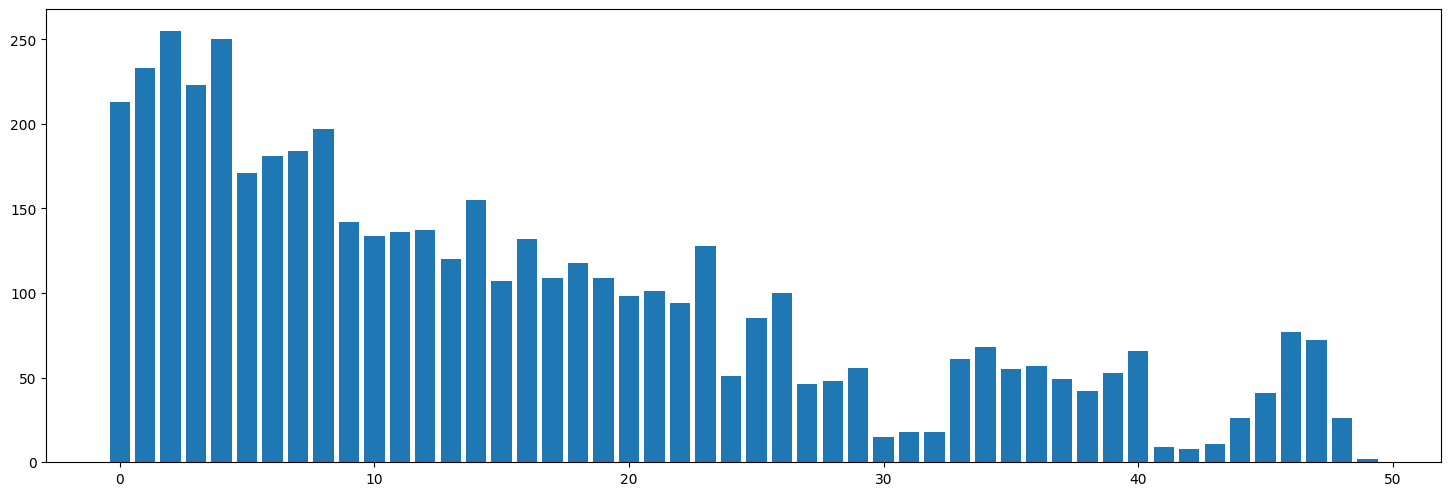

In [30]:
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 
len_car = [len(car_sample[i]) for i in range(0,cars)]
plt.bar(range(0,cars),len_car)

## Creating Dataset and Dataloaders

### Dataset

In [31]:
cl_dataset = list()

for i in range(0,cars):
    tmp = bs_dataset(train_lpath,train_cpath,train_label_path,len_car[i],car_sample[i],BS)
    cl_dataset.append(tmp)

### Dataloader

In [32]:
cl_loader = list()

for i in range(0,cars):
    tmp = DataLoader(
        cl_dataset[i],
        batch_size=BATCH_SIZE,
        pin_memory=True,
        num_workers = n_worker,
        drop_last = True,
        shuffle = True
        )
    cl_loader.append(tmp)

## Model

### Client update

In [33]:
class client():
    
    '''
    Currently using standard trainer to train the model 
    '''
    def __init__(self,model:nn.Module,
                loader:DataLoader,
                epoch:int = epoch_round,
                model_type:str=model_type,
                lr=1e-3):
    
        self.model = model.to(device)
        self.loader = loader
        self.epoch = epoch
        self.model_type = model_type

        self.lr = lr
        self.celoss = nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(model.parameters(),self.lr)
        self.start = time.time()

    def train(self):

        self.model.train()
        self.model.zero_grad()

        for i in range(0,self.epoch):

            # print('-'*10+f' Starting Epoch {i+1} '+'-'*10)
            
            running_loss = 0.0
            running_acc = 0.000
            
            for count,batch in enumerate(self.loader):

                self.opt.zero_grad()

                lidar = batch['lidar'].float().to(device)
                gps = batch['gps'].float().to(device)
                BS = batch['BS'].float().to(device)
                label = batch['label'].long().to(device)

                if self.model_type == 'lg':
                    yhat = self.model(lidar,gps,BS)
                elif self.model_type == 'l':
                    yhat = self.model(lidar)
                else:
                    yhat = self.model(gps,BS)
                
                loss = self.celoss(yhat,label)
                running_loss +=loss.item()
                
                loss.backward()
                self.opt.step()

                top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
                running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)

                # if count%1000 == 0 :
                #     print(f'Cross Entropy loss after {count} iterations is {running_loss/((count+1)*BATCH_SIZE)}. '\
                #           f'Time Elapsed {time.time()-self.start}')
                #     print(f'Accuracy on train after {count} iteration is {running_acc}')
            
            # print(f'Overall iteration completed {count}') #304
            # print('-'*10+f' Epoch {i+1} ends '+'-'*10)
            print(f'Cross Entropy loss after {i+1} epochs is {running_loss/((count+1)*BATCH_SIZE)}'\
                  f'Time Elapsed {time.time()-self.start}')
            print(f'Accuracy on train after {i+1} epochs is {running_acc}')

### Global Server

In [37]:
class fed_server():
    def __init__(self,cars:int,cl_dataset,cl_loader,agg:str=agg,
                model_type:str=model_type,ovr_sample:int=len_train,
                val_loader:DataLoader=val_loader):
        
        self.cars = cars
        self.dataset = cl_dataset
        self.loader = cl_loader
        self.agg = agg
        self.model_type = model_type
        self.ovr_sample = ovr_sample
        self.val_loader = val_loader

        self.create_model() #Global Model
    
    def create_model(self):
        if self.model_type == 'lg':
            self.model = bs_model().to(device)
        elif self.model_type == 'l':
            self.model = lidar_bs_sel().to(device)
        else:
            self.model = gps_bs_sel().to(device)
    
    def per_round(self,epoch):

        #Synchronizing client model with global model at start of each round
        cl_model = [self.model for i in range(0,self.cars)]
        for cmodel in cl_model:
            cmodel.load_state_dict(self.model.state_dict())


        # Training Client Model
        for i in range(0,self.cars):
            print('*'*3+f' Starting Client {i} ' +'*'*3)
            
            if not(len(self.loader[i])) :
                print(f'Not enough samples for client {i}')
                cl_model[i].load_state_dict(self.model.state_dict())
                continue

            tmp = client(cl_model[i],self.loader[i],epoch,self.model_type)
            tmp.train()

        # Global aggregration
        global_dict = self.model.state_dict()

        for k in global_dict.keys():
            if self.agg == 'mean':
                
                global_dict[k] = torch.stack([cl_model[i].state_dict()[k].float() 
                                            for i in range(len(cl_model))], 0).mean(0)
            
            else:
                global_dict[k] = torch.sum(
                                        torch.stack([cl_model[i].state_dict()[k].float()*(float(len(cl_dataset[i]))/float(self.ovr_sample)) 
                                        for i in range(len(cl_model))], 0),
                                        0)
        
        self.model.load_state_dict(global_dict)
        print('Global Aggregration Successfull')
    
    def train(self,cm_rounds:int=cm_rounds,epoch_round:int=epoch_round):

        for i in range(0,cm_rounds):
            
            print('-'*10+f' Staring round {i+1} '+ '-'*10)
            self.per_round(epoch_round)
            
            print('#'*3 + 'Validation Accuracy '+ '#'*3)
            self.val()

    def val(self):

        self.model.eval()
        running_loss = 0.0
        running_acc = 0.000

        for count,batch in enumerate(self.val_loader):

            lidar = batch['lidar'].float().to(device)
            gps = batch['gps'].float().to(device)
            BS = batch['BS'].float().to(device)
            label = batch['label'].long().to(device)

            if self.model_type == 'lg':
                yhat = self.model(lidar,gps,BS)
            elif self.model_type == 'l':
                yhat = self.model(lidar)
            else:
                yhat = self.model(gps,BS)

            top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
            running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)
        
        print(f'Accuracy on val is {running_acc}')

## Training - Federated Learning

In [38]:
federated = fed_server(cars,cl_dataset,cl_loader,agg,model_type,len_train,val_loader)

In [39]:
federated.train(2,1)

---------- Staring round 1 ----------
*** Starting Client 0 ***
Cross Entropy loss after 1 epochs is 0.33768077503960087Time Elapsed 3.3686230182647705
Accuracy on train after 1 epochs is 0.38207547169811323
*** Starting Client 1 ***
Cross Entropy loss after 1 epochs is 0.24755352876823525Time Elapsed 3.4383127689361572
Accuracy on train after 1 epochs is 0.5344827586206895
*** Starting Client 2 ***
Cross Entropy loss after 1 epochs is 0.26294848322868347Time Elapsed 3.7001001834869385
Accuracy on train after 1 epochs is 0.5119047619047621
*** Starting Client 3 ***
Cross Entropy loss after 1 epochs is 0.24267656329003248Time Elapsed 3.388314723968506
Accuracy on train after 1 epochs is 0.5590909090909092
*** Starting Client 4 ***
Cross Entropy loss after 1 epochs is 0.2452349101583804Time Elapsed 3.771109104156494
Accuracy on train after 1 epochs is 0.5725806451612904
*** Starting Client 5 ***
Cross Entropy loss after 1 epochs is 0.28146207829316455Time Elapsed 2.6160356998443604
Accur